# Oil Inventory Estimation

In [45]:
import os
import glob
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.exposure import histogram
from skimage.morphology import remove_small_objects, binary_closing, skeletonize
from scipy.ndimage.interpolation import rotate

## Example Images

We used images of oil refinery sites in Cushing, USA, available [here](https://blog.spaceknow.com/cushing/). The images were most likely captured by DigitalGlobe GeoEye-1. 

### Resolution Assumption

We will assume a resolution of 0.5m

In [46]:
PX_TO_M = 0.5 

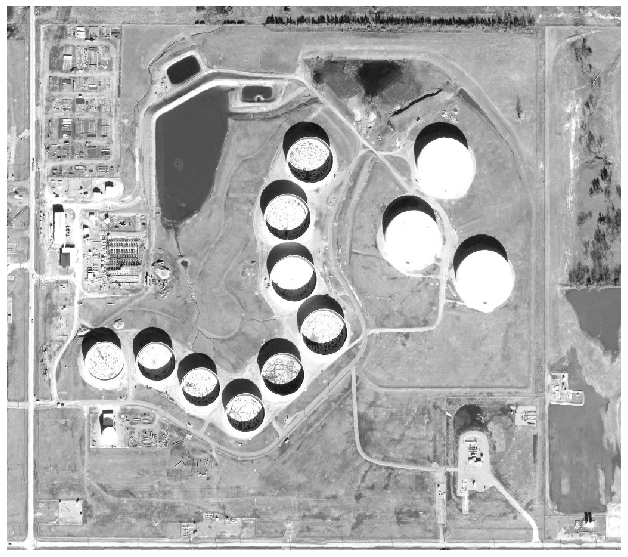

In [47]:
tank = plt.imread('storage_tanks_2.jpg')
f = plt.figure(figsize=(11, 11))
plt.axis('off')
plt.imshow(tank, cmap='gray')

### Bounding Box Detection 

We can simulate the detection by simply cropping one of the tanks from the above image.

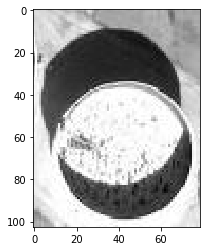

In [48]:
img = cv2.imread('tanks/tank_3.jpg', 0)
plt.imshow(img, cmap='gray')

### Pixel Histogram

Plotting the distribution of the pixel values shows there is good potential for thresholding. 

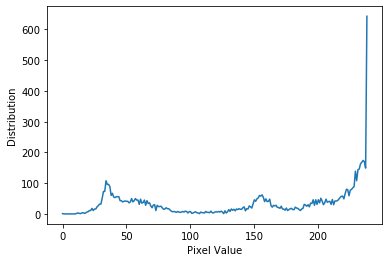

In [49]:
hist, hist_centers = histogram(img)
plt.ylabel('Distribution')
plt.xlabel('Pixel Value')
plt.plot(hist)

### Smooth and Otsu Thresholding

We can smooth out the image by convolving with a Gaussian filter. This removes some of the noise. Then we can apply Otsu thresholding, which applies a threshold value based on the global pixel values. 

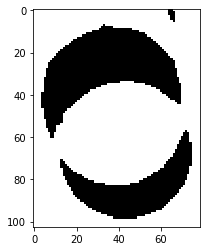

In [50]:
def smooth_and_thresh(img):

    blur = cv2.GaussianBlur(img,(5,5),0)
    
    return cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU)

_, img_bin = smooth_and_thresh(img)

plt.imshow(img_bin, cmap='gray')

### Invert and further noise removal

Our regions of interest should ideally be non-zero, so we invert the values and remove any remaining noise.

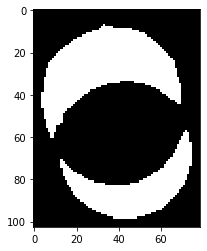

In [51]:
def invert_and_clean(img):
    
    img = ~img
    shadow = img > 0
    clean = remove_small_objects(shadow, min_size=300)
    clean = remove_small_objects(clean, min_size=300)
    
    return np.uint8(clean) 

img_clean = invert_and_clean(img_bin)
plt.imshow(img_clean, cmap='gray')

### Rotate and Distance Transform

We want to measure how far the shadows stretch from the walls, both inner and outer. This means by rotating and applying a simple distance transform, we can determine the shadow length.


### Assumption 1: relative shadow positions

Because we know by visual inspection that the shadows are top and bottom, we can rotate it accordingly. However at scale, we may not know this. We could by applying a grid and looking at non-zero pixel distribution in certain grid boxes. 

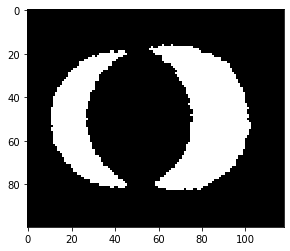

In [52]:
def rotate_img(img):

    return rotate(img, -103, reshape=True)
    
img_rot = rotate_img(img_clean)
plt.imshow(img_rot, cmap='gray')

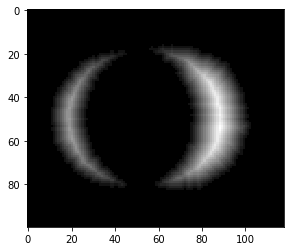

In [53]:
def get_dists(img):
     
    return cv2.distanceTransform(np.uint8(img), cv2.DIST_L2, 3)

dists = get_dists(img_rot)
plt.imshow(dists, cmap='gray')

### Assumption 2: Shadows on equal halves of image

In [54]:
def measure_shadows(dists):
    
    inside_shadow_widths = []
    inside_positions = []
    outside_shadow_widths = []
    outside_positions = []

    for i, row in enumerate(dists):

        row_widths = [j for j in row]

        halfway = int(0.5*len(row_widths))

        in_widths = row_widths[:halfway]
        out_widths = row_widths[halfway:]

        inside_shadow_widths.append(np.round(max(in_widths)*2, 4))
        outside_shadow_widths.append(np.round(max(out_widths)*2, 4))

        xpos_in = in_widths.index(max(in_widths))
        xpos_out = out_widths.index(max(out_widths))

        inside_positions.append((i, xpos_in))
        outside_positions.append((i, xpos_out + halfway))

    inside_profile = [(w, pos) for w, pos in zip(inside_shadow_widths, inside_positions)]
    outside_profile = [(w, pos) for w, pos in zip(outside_shadow_widths, outside_positions)]

    return inside_profile, outside_profile

### Shadow Length Profile 

In [55]:
inside_shadow, outside_shadow = measure_shadows(dists)

print(inside_shadow)

[(0.0, (0, 0)), (0.0, (1, 0)), (0.0, (2, 0)), (0.0, (3, 0)), (0.0, (4, 0)), (0.0, (5, 0)), (0.0, (6, 0)), (0.0, (7, 0)), (0.0, (8, 0)), (0.0, (9, 0)), (0.0, (10, 0)), (0.0, (11, 0)), (0.0, (12, 0)), (0.0, (13, 0)), (0.0, (14, 0)), (0.0, (15, 0)), (0.0, (16, 0)), (1.91, (17, 57)), (1.91, (18, 56)), (1.91, (19, 38)), (2.7386, (20, 38)), (4.6486, (21, 38)), (5.73, (22, 35)), (7.3872, (23, 34)), (7.3872, (24, 33)), (8.2158, (25, 30)), (10.1258, (26, 30)), (10.1258, (27, 28)), (11.2072, (28, 28)), (10.9543, (29, 27)), (10.9543, (30, 26)), (12.0358, (31, 25)), (12.8643, (32, 24)), (13.37, (33, 24)), (12.8643, (34, 23)), (13.6929, (35, 23)), (13.6929, (36, 22)), (14.1986, (37, 22)), (14.7744, (38, 21)), (15.28, (39, 21)), (15.6029, (40, 20)), (16.1086, (41, 20)), (15.28, (42, 19)), (15.28, (43, 19)), (15.28, (44, 19)), (16.1086, (45, 19)), (15.28, (46, 19)), (15.28, (47, 18)), (15.28, (48, 18)), (15.28, (49, 18)), (16.1086, (50, 19)), (15.28, (51, 19)), (15.28, (52, 19)), (15.28, (53, 19)), (

Text(0.5, 1.0, 'Outside Shadow Length Profile')

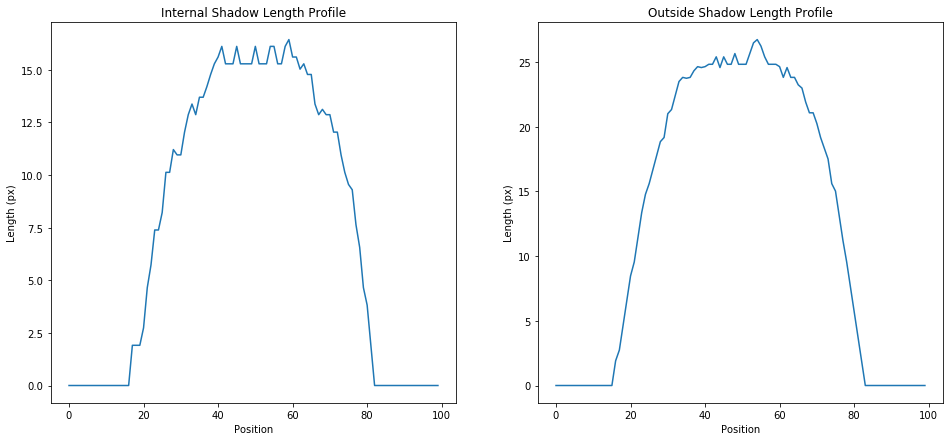

In [56]:
f = plt.figure(figsize=(16,7))
f.add_subplot(121)
plt.plot(range(dists.shape[0]), [w for w,p in inside_shadow])
plt.ylabel('Length (px)')
plt.xlabel('Position')
plt.title('Internal Shadow Length Profile')
f.add_subplot(122)
plt.plot(range(dists.shape[0]), [w for w,p in outside_shadow])
plt.ylabel('Length (px)')
plt.xlabel('Position')
plt.title('Outside Shadow Length Profile')

In [57]:
l1 = max(inside_shadow) 
l2 = max(outside_shadow)

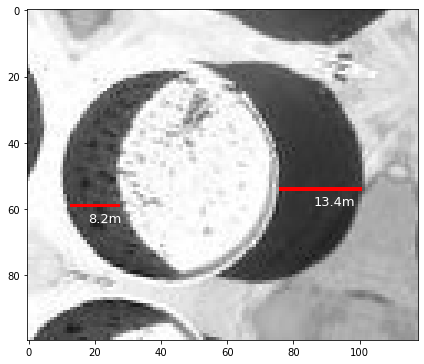

In [58]:
lengths = [l1, l2]

img = cv2.imread('tanks/tank_3.jpg')
img_rot = rotate(img, -103, reshape=True, mode='reflect')

plt.figure(figsize=(7,7))

for l in lengths:
    cv2.line(img_rot, (l[1][1] - (int(0.5*l[0])) + 1, l[1][0]), (l[1][1] + (int(0.5*l[0])) -1, l[1][0]), (255,0,0), 1)
    plt.annotate(s='{}m'.format(round(l[0]*PX_TO_M, 1)), xy=(l[1][1] - 2, l[1][0] + 5), xytext=(l[1][1] - 2, l[1][0] + 5), color='w', fontsize=13, clip_on=True)
    
plt.imshow(img_rot, cmap='gray')

### Imperfections

The rim of the tank and ground clutter seems to be disturbing measurements. This could be dealt with by further smoothing or applying segmentation or edge detection. 

### Storage Calculation 

Using basic formulae for the volume of a cylinder, we can use the difference in shadow lengths to approximate the occupied volume of the tank. 

In [59]:
TANK_HEIGHT = 25 
TANK_DIAMETER = 40 # approximation from http://alloiltank.com/crude-oil-storage-tanks/

TANK_FULL_VOLUME = math.pi * (int(TANK_DIAMETER/2) ** 2) * TANK_HEIGHT

BARREL_TO_M3 = 6.288

# Can calculate diameter from shadow lengths if needed 

INNER_LENGTH = l1[0] 
OUTER_LENGTH = l2[0] 

inner_shadow_start = l1[1][1] - int(INNER_LENGTH/2)
outer_shadow_start = l2[1][1] - int(OUTER_LENGTH/2)

# TANK_DIAMETER = (outer_shadow_start - inner_shadow_start +  5) * PX_TO_M 

def calc_storage(img_path, l1, l2, Full=False):
    
    if l1[0] < 10:
        Full = True
 
    shadow_ratio = l1[0] / l2[0]
    
    tank_occupancy = TANK_FULL_VOLUME * shadow_ratio
            
    if not Full:
        barrels = int(tank_occupancy * BARREL_TO_M3)
        print('{} has an estimated {} barrels of oil'.format(img_path[6:-4], barrels))
    
    if Full: 
        barrels = int(TANK_FULL_VOLUME * BARREL_TO_M3)
        print('{} full with {} barrels'.format(img_path[6:-4], barrels))
        
    return barrels
    
calc_storage('tanks/tank_3.jpg', l1, l2)

tank_3 has an estimated 121388 barrels of oil


121388

# Production Estimation (High Level)

### 1. Automating measurement process.

    1.1 Acquire bounding box detections of an entire refinery.
    
    1.2 Use knowledge of solar elevation or pixel distribution to automate rotation for splitting shadows. 
    
    1.3 Run calculation for each tank and sum for facility. 

### Assumptions

1. All tanks have the same max volume. 
2. A full tank will have a non-existent or miniscule inside shadow. 

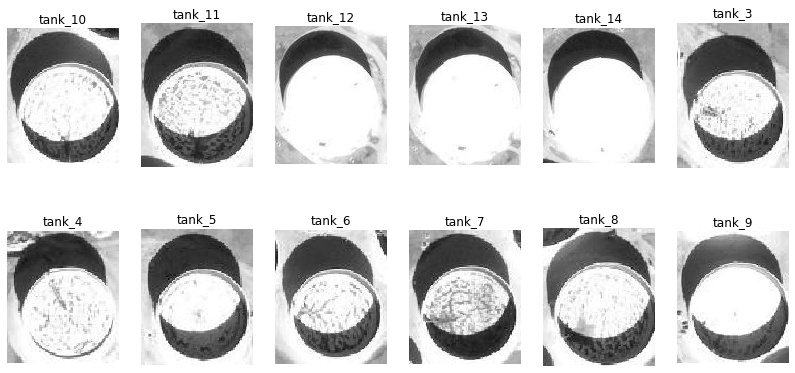

In [60]:
tanks = sorted(glob.glob('tanks/*.jpg'))

plt.figure(figsize=(14,14))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

for i, img_path in enumerate(tanks):
    img = cv2.imread(img_path)
    plt.subplot(2,6,i+1)
    plt.title(img_path[6:-4])
    plt.axis('off')
    plt.imshow(img)

In [61]:
def predict_storage(img_path):
    
    img = cv2.imread(img_path, 0)
    _, img_bin = smooth_and_thresh(img)
    img_clean = invert_and_clean(img_bin)
    img_rot = rotate_img(img_clean)        # Assumption: knowledge of shadow positioning.
    dists = get_dists(img_rot)
    inside_shadow, outside_shadow = measure_shadows(dists)
    
    barrels = calc_storage(img_path, max(inside_shadow), max(outside_shadow))
    
    return barrels

curr_capacity = 0

for img_path in tanks:
    
    barrels = predict_storage(img_path)
    curr_capacity += barrels

print('\nCushing facility capacity: {} million barrels'.format(np.round(curr_capacity/10**6,2)))

tank_10 has an estimated 130612 barrels of oil
tank_11 has an estimated 144396 barrels of oil
tank_12 full with 197543 barrels
tank_13 full with 197543 barrels
tank_14 full with 197543 barrels
tank_3 has an estimated 121388 barrels of oil
tank_4 full with 197543 barrels
tank_5 has an estimated 145355 barrels of oil
tank_6 has an estimated 138345 barrels of oil
tank_7 has an estimated 145355 barrels of oil
tank_8 has an estimated 168871 barrels of oil
tank_9 has an estimated 158548 barrels of oil

Cushing facility capacity: 1.94 million barrels


### 2. Repeat per imaged facility

    Assumption: available imagery (no cloud or fog coverage)
   

### 3. Get wider context through external data sources
    
    3.1 Oil tanker traffic.
    
    3.2 Industry forecasts.
    
    3.3 Company announcements. 
    
    3.4 Trading activity. 